In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using DataFrames
using Plots
using CategoricalArrays
using Random
using Imbalance
using MLJBase: machine, transform
using ScientificTypes
using TableTransforms
using CSV

  Activating project at `~/Documents/GitHub/Imbalance.jl/examples`


### 1. Generate Random Data

Let's start by generating some random imbalanced data. Here we generate data where there are three classes `0, 1, 2` that occur with probability `0.5, 0.2, 0.3` respectively, making `0` the majority class. The data has `4` continuous features and `4` categorical features where the categorical variables have `3, 4, 2, 5` unique values respectively.

In [2]:
rng = Random.default_rng()

num_rows = 100
num_cont_feats = 4
probs = [0.5, 0.2, 0.3]

cat_feats_num_vals = [3, 4, 2, 5]

X, y = generate_imbalanced_data(num_rows, num_cont_feats; probs, cat_feats_num_vals)
X = DataFrame(X)

Row,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.179661,0.799345,0.914285,0.0207499,1.0,1.0,1.0,5.0
2,0.931373,0.0577793,0.437202,0.53995,1.0,1.0,1.0,5.0
3,0.602767,0.172811,0.542216,0.531037,1.0,1.0,1.0,4.0
4,0.805278,0.0887716,0.499888,0.0326524,2.0,2.0,1.0,3.0
5,0.740011,0.301312,0.442435,0.113954,2.0,3.0,1.0,4.0
6,0.479224,0.885141,0.661384,0.388037,3.0,2.0,2.0,2.0
7,0.469029,0.709884,0.494508,0.360574,3.0,4.0,1.0,3.0
8,0.724523,0.943529,0.325882,0.617059,2.0,2.0,2.0,4.0
9,0.325189,0.956575,0.998301,0.379444,1.0,1.0,2.0,4.0


We follow by coercing the columns with few values (i.e., the categorical ones) to the appropriate type (a finite `sci-type` such as `OrderedFactor` or `Multiclass`). This is necessary because the `RandomWalkOversampling` assumes that all categorical features have `sci-type` finite.

In [3]:
X = coerce(X, autotype(X, :few_to_finite))

Row,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
,Float64,Float64,Float64,Float64,Cat…,Cat…,Cat…,Cat…
1,0.179661,0.799345,0.914285,0.0207499,1.0,1.0,1.0,5.0
2,0.931373,0.0577793,0.437202,0.53995,1.0,1.0,1.0,5.0
3,0.602767,0.172811,0.542216,0.531037,1.0,1.0,1.0,4.0
4,0.805278,0.0887716,0.499888,0.0326524,2.0,2.0,1.0,3.0
5,0.740011,0.301312,0.442435,0.113954,2.0,3.0,1.0,4.0
6,0.479224,0.885141,0.661384,0.388037,3.0,2.0,2.0,2.0
7,0.469029,0.709884,0.494508,0.360574,3.0,4.0,1.0,3.0
8,0.724523,0.943529,0.325882,0.617059,2.0,2.0,2.0,4.0
9,0.325189,0.956575,0.998301,0.379444,1.0,1.0,2.0,4.0


### 2. Apply Random Walk Oversampling

#### Using Imbalance Only

Applying Random Walk Oversampling using the standard API is very straightforward. There only main hyperparameter is wanted ratios of each class relative to the majority class `ratios`. In the example below, we want all three classes to have `120%` of the data that was present in the majority class (i.e., class `0` prior to applying the algorithm)

In [4]:
Xover, yover = random_walk_oversample(X, y; ratios = Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng = 42)

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01



Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
  class:  1


(168×8 DataFrame
 Row │ Column1      Column2    Column3    Column4    Column5  Column6  Column7 ⋯
     │ Float64      Float64    Float64    Float64    Cat…     Cat…     Cat…    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  0.179661    0.799345   0.914285   0.0207499  1.0      1.0      1.0     ⋯
   2 │  0.931373    0.0577793  0.437202   0.53995    1.0      1.0      1.0
   3 │  0.602767    0.172811   0.542216   0.531037   1.0      1.0      1.0
   4 │  0.805278    0.0887716  0.499888   0.0326524  2.0      2.0      1.0
   5 │  0.740011    0.301312   0.442435   0.113954   2.0      3.0      1.0     ⋯
   6 │  0.479224    0.885141   0.661384   0.388037   3.0      2.0      2.0
   7 │  0.469029    0.709884   0.494508   0.360574   3.0      4.0      1.0
   8 │  0.724523    0.943529   0.325882   0.617059   2.0      2.0      2.0
  ⋮  │      ⋮           ⋮          ⋮          ⋮         ⋮        ⋮        ⋮    ⋱
 162 │  0.905592    0.227513   0.806568   0.834

#### Using MLJ

To use `MLJ`, we first instantiate the model using keyword parameters, wrap it in a machine and the transform the machine with our input data `X,y`.

In [5]:
model = Imbalance.MLJ.RandomWalkOversampler(ratios=Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng=42)
mach = machine(model)
Xover, yover = transform(mach, X, y)

(168×8 DataFrame
 Row │ Column1      Column2    Column3    Column4    Column5  Column6  Column7 ⋯
     │ Float64      Float64    Float64    Float64    Cat…     Cat…     Cat…    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  0.179661    0.799345   0.914285   0.0207499  1.0      1.0      1.0     ⋯
   2 │  0.931373    0.0577793  0.437202   0.53995    1.0      1.0      1.0
   3 │  0.602767    0.172811   0.542216   0.531037   1.0      1.0      1.0
   4 │  0.805278    0.0887716  0.499888   0.0326524  2.0      2.0      1.0
   5 │  0.740011    0.301312   0.442435   0.113954   2.0      3.0      1.0     ⋯
   6 │  0.479224    0.885141   0.661384   0.388037   3.0      2.0      2.0
   7 │  0.469029    0.709884   0.494508   0.360574   3.0      4.0      1.0
   8 │  0.724523    0.943529   0.325882   0.617059   2.0      2.0      2.0
  ⋮  │      ⋮           ⋮          ⋮          ⋮         ⋮        ⋮        ⋮    ⋱
 162 │  0.905592    0.227513   0.806568   0.834

#### Using TableTransforms

Let's consider an example with table transforms on a more realistic dataset. This time the categorical variables are strings so all we had to do is coerce `strings`to the `multiclass` type. `random_walk_oversample` will take of encoding them and decoding them before and after applying the actual algorithm.

In [13]:
# For TableTransforms
Xy = CSV.read("./datasets/churn.csv", DataFrame)
y_ind = 17
Xy = coerce(Xy, autotype(Xy, :string_to_multiclass))

Row,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
,Int64,Int64,Cat…,Int64,Cat…,Cat…,Int64,Int64,Float64,Int64,Int64,Int64,Float64,Int64
1,1,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,1.01349e5,1
2,2,15647311,Hill,608,Spain,Female,41,1,83807.9,1,0,1,1.12543e5,0
3,3,15619304,Onio,502,France,Female,42,8,1.59661e5,3,1,0,1.13932e5,1
4,4,15701354,Boni,699,France,Female,39,1,0.0,2,0,0,93826.6,0
5,5,15737888,Mitchell,850,Spain,Female,43,2,1.25511e5,1,1,1,79084.1,0
6,6,15574012,Chu,645,Spain,Male,44,8,1.13756e5,2,1,0,1.49757e5,1
7,7,15592531,Bartlett,822,France,Male,50,7,0.0,2,1,1,10062.8,0
8,8,15656148,Obinna,376,Germany,Female,29,4,1.15047e5,4,1,0,1.19347e5,1
9,9,15792365,He,501,France,Male,44,4,1.42051e5,2,0,1,74940.5,0


Now we instantiate the model and simply pass the data to it using the pipeline operator `|>`. This is equivalent to calling `apply` from table transforms.

In [14]:
using Imbalance: TableTransforms.RandomWalkOversampler
y_ind = 14
model_t = RandomWalkOversampler(y_ind, ratios=Dict(1=> 1.2, 2=>1.2, 3=>1.2, 4=>1.2), rng=42)
Xyover = Xy |> model_t

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Row,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
,Float64,Float64,Cat…,Float64,Cat…,Cat…,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,1.56346e7,Hargrave,619.0,France,Female,42.0,2.0,0.0,1.0,1.0,1.0,1.01349e5,1.0
2,2.0,1.56473e7,Hill,608.0,Spain,Female,41.0,1.0,83807.9,1.0,0.0,1.0,1.12543e5,0.0
3,3.0,1.56193e7,Onio,502.0,France,Female,42.0,8.0,1.59661e5,3.0,1.0,0.0,1.13932e5,1.0
4,4.0,1.57014e7,Boni,699.0,France,Female,39.0,1.0,0.0,2.0,0.0,0.0,93826.6,0.0
5,5.0,1.57379e7,Mitchell,850.0,Spain,Female,43.0,2.0,1.25511e5,1.0,1.0,1.0,79084.1,0.0
6,6.0,1.5574e7,Chu,645.0,Spain,Male,44.0,8.0,1.13756e5,2.0,1.0,0.0,1.49757e5,1.0
7,7.0,1.55925e7,Bartlett,822.0,France,Male,50.0,7.0,0.0,2.0,1.0,1.0,10062.8,0.0
8,8.0,1.56561e7,Obinna,376.0,Germany,Female,29.0,4.0,1.15047e5,4.0,1.0,0.0,1.19347e5,1.0
9,9.0,1.57924e7,He,501.0,France,Male,44.0,4.0,1.42051e5,2.0,0.0,1.0,74940.5,0.0


In [8]:
model_t = RandomWalkOversampler(5, ratios=Dict(1=> 1.2, 2=>1.2, 3=>1.2, 4=>1.2), rng=42)
Xyover = Xy |> model_t

Row,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
,Float64,Float64,Cat…,Float64,Cat…,Cat…,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,1.56346e7,Hargrave,619.0,France,Female,42.0,2.0,0.0,1.0,1.0,1.0,1.01349e5,1.0
2,2.0,1.56473e7,Hill,608.0,Spain,Female,41.0,1.0,83807.9,1.0,0.0,1.0,1.12543e5,0.0
3,3.0,1.56193e7,Onio,502.0,France,Female,42.0,8.0,1.59661e5,3.0,1.0,0.0,1.13932e5,1.0
4,4.0,1.57014e7,Boni,699.0,France,Female,39.0,1.0,0.0,2.0,0.0,0.0,93826.6,0.0
5,5.0,1.57379e7,Mitchell,850.0,Spain,Female,43.0,2.0,1.25511e5,1.0,1.0,1.0,79084.1,0.0
6,6.0,1.5574e7,Chu,645.0,Spain,Male,44.0,8.0,1.13756e5,2.0,1.0,0.0,1.49757e5,1.0
7,7.0,1.55925e7,Bartlett,822.0,France,Male,50.0,7.0,0.0,2.0,1.0,1.0,10062.8,0.0
8,8.0,1.56561e7,Obinna,376.0,Germany,Female,29.0,4.0,1.15047e5,4.0,1.0,0.0,1.19347e5,1.0
9,9.0,1.57924e7,He,501.0,France,Male,44.0,4.0,1.42051e5,2.0,0.0,1.0,74940.5,0.0


### 3. Plot the Results

We can finally plot the data before and after to validate the results.

    Updating registry at `~/.julia/registries/General`


    Updating git-repo `https://github.com/JuliaRegistries/General.git`


   Resolving package versions...


  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/Project.toml`
  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/Manifest.toml`


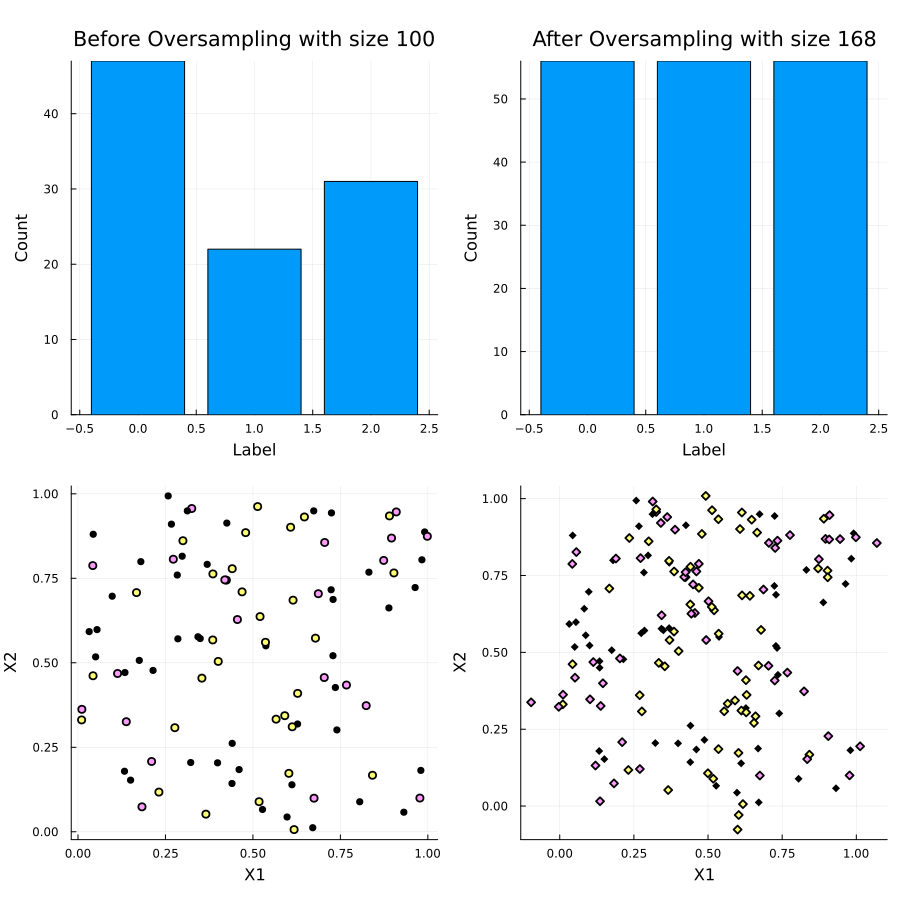

In [9]:
include("plot.jl")                      # provides a plot function to compare results
plot_data(y, yover, X, Xover)